In [74]:
# Cálculo de isoyetas y polígonos de thiessen.

import numpy as np
import pandas as pd

from scipy import spatial

from matplotlib import pyplot as plt

import geopandas as gpd
import shapely as shp

In [75]:
# Dirección de los datos.
path = "../Material/Clases/Examen 1/"

# Nombre de la cuenca.
estaciones_n = "ESTACIONES_NOROESTE.csv"

# Datos de estaciones.
nombre_e = "Estaciones_Guerrero_1980.csv"

In [312]:
# Cargamos la lista de estaciones.
estaciones = pd.read_csv(path + estaciones_n)

# Nombres de archivos
estaciones["ARCHIVO"] = estaciones["ESTACION"].apply(
    lambda x: f"Estacion_{x}__90_dias.csv" )

# Creamos un punto con las coordenadas.
estaciones["geometry"] = None
estaciones["geometry"] = gpd.points_from_xy(
    estaciones["LONGITUD"], estaciones["LATITUD"])

# Creamos un GeoDataFrame.
estaciones = gpd.GeoDataFrame(estaciones, geometry = "geometry", crs = 4326)
# A coordenadas Cónica Conforme de Lambert ITRF2008.
CRS = 6372
estaciones = estaciones.to_crs(CRS)

# Actualizamos x, y.
estaciones["x"] = estaciones.centroid.x
estaciones["y"] = estaciones.centroid.y

# Datos.
estaciones

ESTACION    LATITUD    LONGITUD           ESTADO  \
0                 EJIDO_NUEVO_LEON  32.414440 -115.192500  Baja California   
1                    ISLA_CORONADO  32.415600 -117.248100  Baja California   
2                   ISLA_GUADALUPE  28.882800 -118.293100  Baja California   
3                       LARUMOROSA  32.272222 -116.205556  Baja California   
4                     MEXICALI_EMA  32.666670 -115.457778  Baja California   
5                   PLAYASROSARITO  32.377500 -117.071389  Baja California   
6   PRESAABELARDOLRODRIGUEZTIJUANA  32.447222 -116.908333  Baja California   
7   PRESAEMILIOLOPEZZAMORAENSENADA  31.891389 -116.603333  Baja California   
8                       SAN_FELIPE  31.028050 -114.846660  Baja California   
9                       SANQUINTIN  30.531667 -115.837500  Baja California   
10                          TECATE  32.566670 -116.661389  Baja California   

             MUNICIPIO  ALTITUD  \
0             Mexicali     14.0   
1              Tijuana     76.0   
2             Ensenada     23.0   
3               Tecate   1262.0   
4             Mexicali     14.0   
5   Playas de Rosarito     36.9   
6              Tijuana    156.0   
7             Ensenada     32.0   
8             Mexicali     27.0   
9             Ensenada     32.0   
10              Tecate    583.7   

                                              ARCHIVO  \
0              Estacion_EJIDO_NUEVO_LEON__90_dias.csv   
1                 Estacion_ISLA_CORONADO__90_dias.csv   
2                Estacion_ISLA_GUADALUPE__90_dias.csv   
3                    Estacion_LARUMOROSA__90_dias.csv   
4                  Estacion_MEXICALI_EMA__90_dias.csv   
5                Estacion_PLAYASROSARITO__90_dias.csv   
6   Estacion_PRESAABELARDOLRODRIGUEZTIJUANA__90_di...   
7   Estacion_PRESAEMILIOLOPEZZAMORAENSENADA__90_di...   
8                    Estacion_SAN_FELIPE__90_dias.csv   
9                    Estacion_SANQUINTIN__90_dias.csv   
10                       Estacion_TECATE__90_dias.csv   

                           geometry             x             y  
0   POINT (1252350.014 2318259.450)  1.252350e+06  2.318259e+06  
1   POINT (1058643.571 2337659.122)  1.058644e+06  2.337659e+06  
2    POINT (915764.064 1958404.802)  9.157641e+05  1.958405e+06  
3   POINT (1155275.080 2311612.307)  1.155275e+06  2.311612e+06  
4   POINT (1229974.568 2348638.310)  1.229975e+06  2.348638e+06  
5   POINT (1074839.464 2331663.295)  1.074839e+06  2.331663e+06  
6   POINT (1091009.953 2337794.109)  1.091010e+06  2.337794e+06  
7   POINT (1113431.313 2273135.331)  1.113431e+06  2.273135e+06  
8   POINT (1271148.725 2161421.674)  1.271149e+06  2.161422e+06  
9   POINT (1171337.908 2115317.077)  1.171338e+06  2.115317e+06  
10  POINT (1115628.012 2348658.379)  1.115628e+06  2.348658e+06

In [284]:
# Graficamos las estaciones.
estaciones.explore()

In [154]:
df = []
df_d = []
ll_l = ["2023-01-01"]
ll = [0] * len(ll_l)

for i in range( estaciones.shape[0] ): 
    df.append( pd.read_csv(path + estaciones.loc[i, "ARCHIVO"],
        skiprows = 9, index_col = "Fecha Local", 
        usecols = ["Fecha Local", "Precipitacion (mm)"]) )
    df[i].index = pd.to_datetime( df[i].index )

    df_d.append( df[i].resample("D").sum().sort_values(
        "Precipitacion (mm)", ascending = False) )
    for j in range( len(ll_l) ):
        k = df_d[i].head(6).index.isin([ll_l[j]]).sum()
        ll[j] += k
    if ll[j] == 0: 
        print(f"Estación sin precipitacion: {estaciones.loc[i, 'ESTACION']}")


print(f"Cantidad de estaciones con precipitacion el {ll_l[0]}: {ll[0]}")
print(f"Total de estaciones: {estaciones.shape[0]}")

Cantidad de estaciones con precipitacion el 2023-01-01: 11
Total de estaciones: 11


In [155]:
i = 0

pluviograma = pd.read_csv(path + estaciones.loc[i, "ARCHIVO"],
        skiprows = 9, index_col = "Fecha Local", 
        usecols = ["Fecha Local", "Precipitacion (mm)"])
pluviograma.index = pd.to_datetime( pluviograma.index )
pluviograma = pluviograma[ ( pluviograma.index.month.isin([1])
        & pluviograma.index.day.isin([1]) ) ].iloc[50:-9]
pluviograma.columns = [ estaciones.loc[0, "ESTACION"] ]

for i in range( 1, estaciones.shape[0] ): 
    df = pd.read_csv(path + estaciones.loc[i, "ARCHIVO"],
        skiprows = 9, index_col = "Fecha Local", 
        usecols = ["Fecha Local", "Precipitacion (mm)"])
    df.index = pd.to_datetime( df.index )
    df = df[ ( df.index.month.isin([1])
        & df.index.day.isin([1, 1]) ) ].iloc[50:-9]
    
    pluviograma[ estaciones.loc[i, "ESTACION"] ] = df["Precipitacion (mm)"]

pluviograma.iloc[-1, 1] = 0
pluviograma.iloc[-4, 1] = 0.2
pluviograma.iloc[-7, 1] = 0.5

pluviograma

EJIDO_NUEVO_LEON  ISLA_CORONADO  ISLA_GUADALUPE  \
Fecha Local                                                            
2023-01-01 15:30:00               0.0            NaN             NaN   
2023-01-01 15:20:00               0.0            NaN             NaN   
2023-01-01 15:10:00               0.0            NaN             NaN   
2023-01-01 15:00:00               0.0            NaN             NaN   
2023-01-01 14:50:00               0.0            NaN             NaN   
...                               ...            ...             ...   
2023-01-01 02:10:00               0.0            NaN             NaN   
2023-01-01 02:00:00               0.0            0.2             NaN   
2023-01-01 01:50:00               0.0            NaN             NaN   
2023-01-01 01:40:00               0.0            NaN             NaN   
2023-01-01 01:30:00               0.0            0.0             NaN   

                     LARUMOROSA  MEXICALI_EMA  PLAYASROSARITO  \
Fecha Local                                                     
2023-01-01 15:30:00        0.00           0.0             0.0   
2023-01-01 15:20:00        0.00           0.0             0.0   
2023-01-01 15:10:00        0.25           0.0             0.0   
2023-01-01 15:00:00        0.00           0.0             0.0   
2023-01-01 14:50:00        0.00           0.0             0.0   
...                         ...           ...             ...   
2023-01-01 02:10:00        0.00           0.0             0.4   
2023-01-01 02:00:00        0.00           0.0             0.0   
2023-01-01 01:50:00        0.00           0.0             0.0   
2023-01-01 01:40:00        0.00           0.0             0.0   
2023-01-01 01:30:00        0.00           0.0             0.0   

                     PRESAABELARDOLRODRIGUEZTIJUANA  \
Fecha Local                                           
2023-01-01 15:30:00                             0.0   
2023-01-01 15:20:00                             0.0   
2023-01-01 15:10:00                             0.0   
2023-01-01 15:00:00                             0.0   
2023-01-01 14:50:00                             0.0   
...                                             ...   
2023-01-01 02:10:00                             0.0   
2023-01-01 02:00:00                             0.0   
2023-01-01 01:50:00                             0.0   
2023-01-01 01:40:00                             0.0   
2023-01-01 01:30:00                             0.0   

                     PRESAEMILIOLOPEZZAMORAENSENADA  SAN_FELIPE  SANQUINTIN  \
Fecha Local                                                                   
2023-01-01 15:30:00                             0.0         0.0         0.0   
2023-01-01 15:20:00                             0.0         0.0         0.0   
2023-01-01 15:10:00                             0.0         0.0         0.0   
2023-01-01 15:00:00                             0.0         0.0         0.0   
2023-01-01 14:50:00                             0.0         0.0         0.0   
...                                             ...         ...         ...   
2023-01-01 02:10:00                             0.0         0.0         0.0   
2023-01-01 02:00:00                             0.0         0.0         0.0   
2023-01-01 01:50:00                             0.0         0.0         0.0   
2023-01-01 01:40:00                             0.0         0.0         0.0   
2023-01-01 01:30:00                             0.0         0.0         0.0   

                     TECATE  
Fecha Local                  
2023-01-01 15:30:00     0.2  
2023-01-01 15:20:00     0.2  
2023-01-01 15:10:00     0.2  
2023-01-01 15:00:00     0.2  
2023-01-01 14:50:00     0.2  
...                     ...  
2023-01-01 02:10:00     0.0  
2023-01-01 02:00:00     0.0  
2023-01-01 01:50:00     0.0  
2023-01-01 01:40:00     0.0  
2023-01-01 01:30:00     0.0  

[85 rows x 11 columns]

Index(['EJIDO_NUEVO_LEON', 'ISLA_CORONADO', 'ISLA_GUADALUPE', 'LARUMOROSA',
       'MEXICALI_EMA', 'PLAYASROSARITO', 'PRESAABELARDOLRODRIGUEZTIJUANA',
       'PRESAEMILIOLOPEZZAMORAENSENADA', 'SAN_FELIPE', 'SANQUINTIN', 'TECATE'],
      dtype='object')

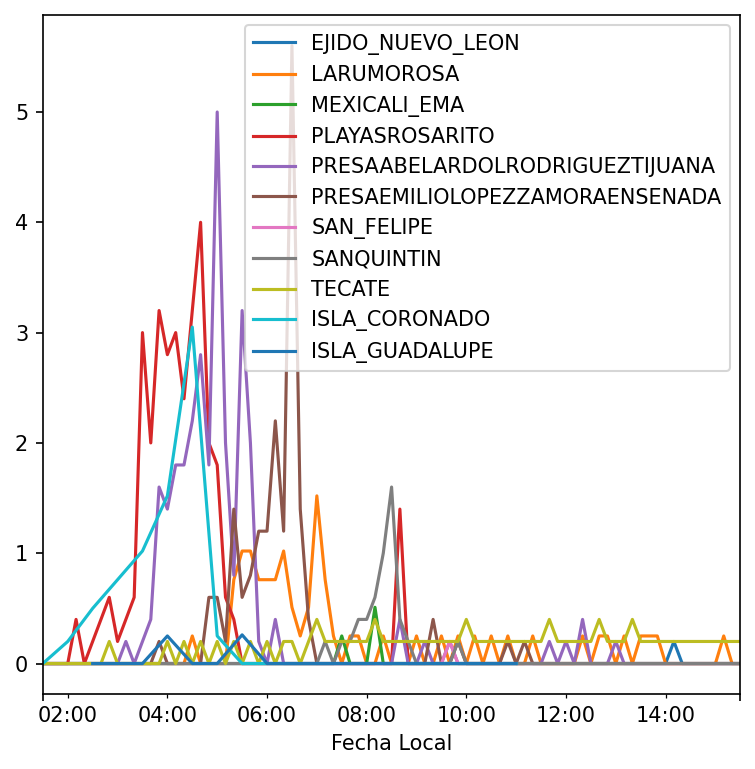

In [156]:
# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

pluviograma.drop( ["ISLA_CORONADO", "ISLA_GUADALUPE"], axis = 1).plot(ax = ax)
pluviograma[["ISLA_CORONADO", "ISLA_GUADALUPE"]].iloc[27::3].plot(ax = ax)
pluviograma.columns

In [157]:
# Subcuencas.

RH = "RH01"

subc = gpd.read_file(path + "subcuenca.shp")
subc = subc.to_crs(crs = CRS)
subc["CVE_RH"] = subc["CVE_SUBCUE"].apply(lambda x: x[0:4])
subc["AREA"] = subc.area
subc["PERIMETRO"] = subc.length
subc[subc["CVE_RH"] == RH].explore()

In [313]:
buffer = 110000
bounds = subc[subc["CVE_RH"] == RH].total_bounds
bbox = [ [ bounds[0] - buffer, bounds[1] - buffer ],
         [ ( bounds[0] + bounds[2] ) / 2, bounds[1] - buffer ],
         [ bounds[2] + buffer, bounds[1] - buffer ],
         [ bounds[2] + buffer, ( bounds[1] + bounds[3] ) / 2 ],
         [ bounds[2] + buffer, bounds[3] + buffer ],
         [ ( bounds[0] + bounds[2] ) / 2, bounds[3] + buffer ],
         [ bounds[0] - buffer, bounds[3] + buffer ],
         [ bounds[0] - buffer, ( bounds[1] + bounds[3] ) / 2 ] ]
for i in range( len(bbox) ):
    bbox[i] = ( [f"B{i + 1}"] + [None] * 6
        + [shp.geometry.Point(bbox[i]), bbox[i][0], bbox[i][1] ] )
estaciones = pd.concat([estaciones,
    pd.DataFrame(bbox, columns = estaciones.columns)]
    ).reset_index( drop = True )

estaciones

ESTACION    LATITUD    LONGITUD           ESTADO  \
0                 EJIDO_NUEVO_LEON  32.414440 -115.192500  Baja California   
1                    ISLA_CORONADO  32.415600 -117.248100  Baja California   
2                   ISLA_GUADALUPE  28.882800 -118.293100  Baja California   
3                       LARUMOROSA  32.272222 -116.205556  Baja California   
4                     MEXICALI_EMA  32.666670 -115.457778  Baja California   
5                   PLAYASROSARITO  32.377500 -117.071389  Baja California   
6   PRESAABELARDOLRODRIGUEZTIJUANA  32.447222 -116.908333  Baja California   
7   PRESAEMILIOLOPEZZAMORAENSENADA  31.891389 -116.603333  Baja California   
8                       SAN_FELIPE  31.028050 -114.846660  Baja California   
9                       SANQUINTIN  30.531667 -115.837500  Baja California   
10                          TECATE  32.566670 -116.661389  Baja California   
11                              B1        NaN         NaN             None   
12                              B2        NaN         NaN             None   
13                              B3        NaN         NaN             None   
14                              B4        NaN         NaN             None   
15                              B5        NaN         NaN             None   
16                              B6        NaN         NaN             None   
17                              B7        NaN         NaN             None   
18                              B8        NaN         NaN             None   

             MUNICIPIO  ALTITUD  \
0             Mexicali     14.0   
1              Tijuana     76.0   
2             Ensenada     23.0   
3               Tecate   1262.0   
4             Mexicali     14.0   
5   Playas de Rosarito     36.9   
6              Tijuana    156.0   
7             Ensenada     32.0   
8             Mexicali     27.0   
9             Ensenada     32.0   
10              Tecate    583.7   
11                None      NaN   
12                None      NaN   
13                None      NaN   
14                None      NaN   
15                None      NaN   
16                None      NaN   
17                None      NaN   
18                None      NaN   

                                              ARCHIVO  \
0              Estacion_EJIDO_NUEVO_LEON__90_dias.csv   
1                 Estacion_ISLA_CORONADO__90_dias.csv   
2                Estacion_ISLA_GUADALUPE__90_dias.csv   
3                    Estacion_LARUMOROSA__90_dias.csv   
4                  Estacion_MEXICALI_EMA__90_dias.csv   
5                Estacion_PLAYASROSARITO__90_dias.csv   
6   Estacion_PRESAABELARDOLRODRIGUEZTIJUANA__90_di...   
7   Estacion_PRESAEMILIOLOPEZZAMORAENSENADA__90_di...   
8                    Estacion_SAN_FELIPE__90_dias.csv   
9                    Estacion_SANQUINTIN__90_dias.csv   
10                       Estacion_TECATE__90_dias.csv   
11                                               None   
12                                               None   
13                                               None   
14                                               None   
15                                               None   
16                                               None   
17                                               None   
18                                               None   

                           geometry             x             y  
0   POINT (1252350.014 2318259.450)  1.252350e+06  2.318259e+06  
1   POINT (1058643.571 2337659.122)  1.058644e+06  2.337659e+06  
2    POINT (915764.064 1958404.802)  9.157641e+05  1.958405e+06  
3   POINT (1155275.080 2311612.307)  1.155275e+06  2.311612e+06  
4   POINT (1229974.568 2348638.310)  1.229975e+06  2.348638e+06  
5   POINT (1074839.464 2331663.295)  1.074839e+06  2.331663e+06  
6   POINT (1091009.953 2337794.109)  1.091010e+06  2.337794e+06  
7   POINT (1113431.313 2273135.331)  1.113431e+06  2.273135e+06  
8   POINT (1271148.725 216142

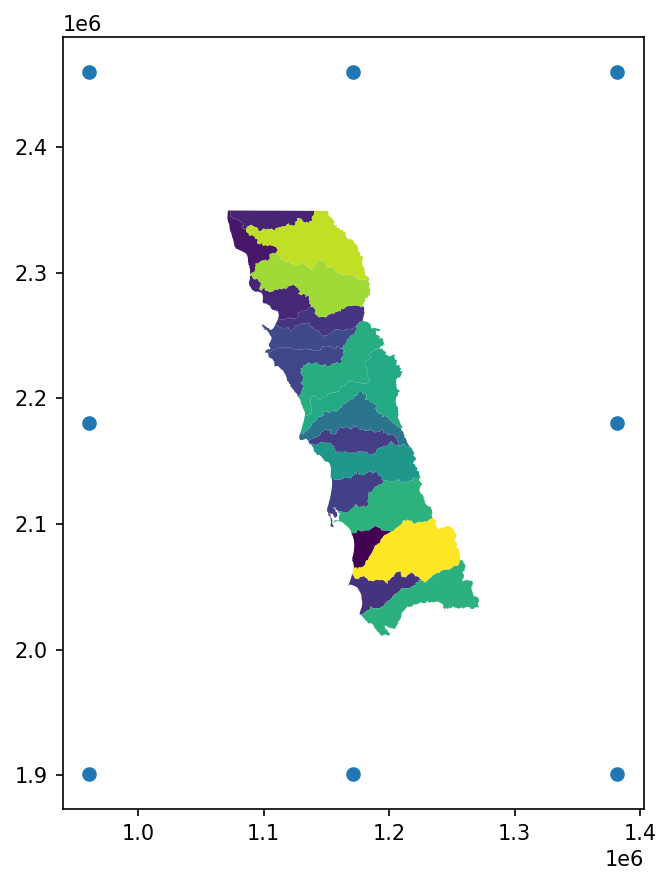

In [314]:
# Límites

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos las subcuenca.
subc[subc["CVE_RH"] == "RH01"].plot("AREA", ax = ax)
# Graficamos los límites.
estaciones[11:].plot(ax = ax)

fig.tight_layout()
plt.show()

In [320]:
# Polígonos de Thiessen

# Creamos los polígonos de Thiessen.
Thiessen = spatial.Voronoi( estaciones[ ["x", "y"] ] )

# Extraemos los polígonos de Thiessen, los convertimos en geometrías
# de Shapely y los agregamos al geoDataFrame de Estaciones.

# Lista de geometrías de Shapely.
Poly_th = []

# Iteramos para cada lista de vértices que forman un polígono.
for i in Thiessen.point_region:

    # Creamos la lista de vértices.
    Ver_th = []

    # Saltamos las listas vacías.
    if len(Thiessen.regions[i]) == 0: pass
    else:
        if -1 in Thiessen.regions[i]:
            Poly_th.append( shp.geometry.Polygon( ) )
    
        # Agregamos cada vértice que corresponde al polígono de Thiessen.
        else:
            for j in Thiessen.regions[i]:
                Ver_th.append( Thiessen.vertices[j] )

            # Agregamos nuevamente el primer vértice para cerrar el polígono.
            Ver_th.append( Ver_th[0] )

            # Convertimos a geometría de shapely.
            Poly_th.append( shp.geometry.Polygon( Ver_th ) )

# Creamos una columna del GeoDataframe con los polígonos de Thiessen.
estaciones["Thiessen"] = Poly_th
# Establecemos como la geometría de trabajo.
estaciones = estaciones.set_geometry("Thiessen")

# Datos.
estaciones

ESTACION    LATITUD    LONGITUD           ESTADO  \
0                 EJIDO_NUEVO_LEON  32.414440 -115.192500  Baja California   
1                    ISLA_CORONADO  32.415600 -117.248100  Baja California   
2                   ISLA_GUADALUPE  28.882800 -118.293100  Baja California   
3                       LARUMOROSA  32.272222 -116.205556  Baja California   
4                     MEXICALI_EMA  32.666670 -115.457778  Baja California   
5                   PLAYASROSARITO  32.377500 -117.071389  Baja California   
6   PRESAABELARDOLRODRIGUEZTIJUANA  32.447222 -116.908333  Baja California   
7   PRESAEMILIOLOPEZZAMORAENSENADA  31.891389 -116.603333  Baja California   
8                       SAN_FELIPE  31.028050 -114.846660  Baja California   
9                       SANQUINTIN  30.531667 -115.837500  Baja California   
10                          TECATE  32.566670 -116.661389  Baja California   
11                              B1        NaN         NaN             None   
12                              B2        NaN         NaN             None   
13                              B3        NaN         NaN             None   
14                              B4        NaN         NaN             None   
15                              B5        NaN         NaN             None   
16                              B6        NaN         NaN             None   
17                              B7        NaN         NaN             None   
18                              B8        NaN         NaN             None   

             MUNICIPIO  ALTITUD  \
0             Mexicali     14.0   
1              Tijuana     76.0   
2             Ensenada     23.0   
3               Tecate   1262.0   
4             Mexicali     14.0   
5   Playas de Rosarito     36.9   
6              Tijuana    156.0   
7             Ensenada     32.0   
8             Mexicali     27.0   
9             Ensenada     32.0   
10              Tecate    583.7   
11                None      NaN   
12                None      NaN   
13                None      NaN   
14                None      NaN   
15                None      NaN   
16                None      NaN   
17                None      NaN   
18                None      NaN   

                                              ARCHIVO  \
0              Estacion_EJIDO_NUEVO_LEON__90_dias.csv   
1                 Estacion_ISLA_CORONADO__90_dias.csv   
2                Estacion_ISLA_GUADALUPE__90_dias.csv   
3                    Estacion_LARUMOROSA__90_dias.csv   
4                  Estacion_MEXICALI_EMA__90_dias.csv   
5                Estacion_PLAYASROSARITO__90_dias.csv   
6   Estacion_PRESAABELARDOLRODRIGUEZTIJUANA__90_di...   
7   Estacion_PRESAEMILIOLOPEZZAMORAENSENADA__90_di...   
8                    Estacion_SAN_FELIPE__90_dias.csv   
9                    Estacion_SANQUINTIN__90_dias.csv   
10                       Estacion_TECATE__90_dias.csv   
11                                               None   
12                                               None   
13                                               None   
14                                               None   
15                                               None   
16                                               None   
17                                               None   
18                                               None   

                           geometry             x             y  \
0   POINT (1252350.014 2318259.450)  1.252350e+06  2.318259e+06   
1   POINT (1058643.571 2337659.122)  1.058644e+06  2.337659e+06   
2    POINT (915764.064 1958404.802)  9.157641e+05  1.958405e+06   
3   POINT (1155275.080 2311612.307)  1.155275e+06  2.311612e+06   
4   POINT (1229974.568 2348638.310)  1.229975e+06  2.348638e+06   
5   POINT (1074839.464 2331663.295)  1.074839e+06  2.331663e+06   
6   POINT (1091009.953 2337794.109)  1.091010e+06  2.337794e+06   
7   POINT (1113431.313 2273135.331)  1.113431e+06  2.273135e+06   
8   POINT (1271148.7

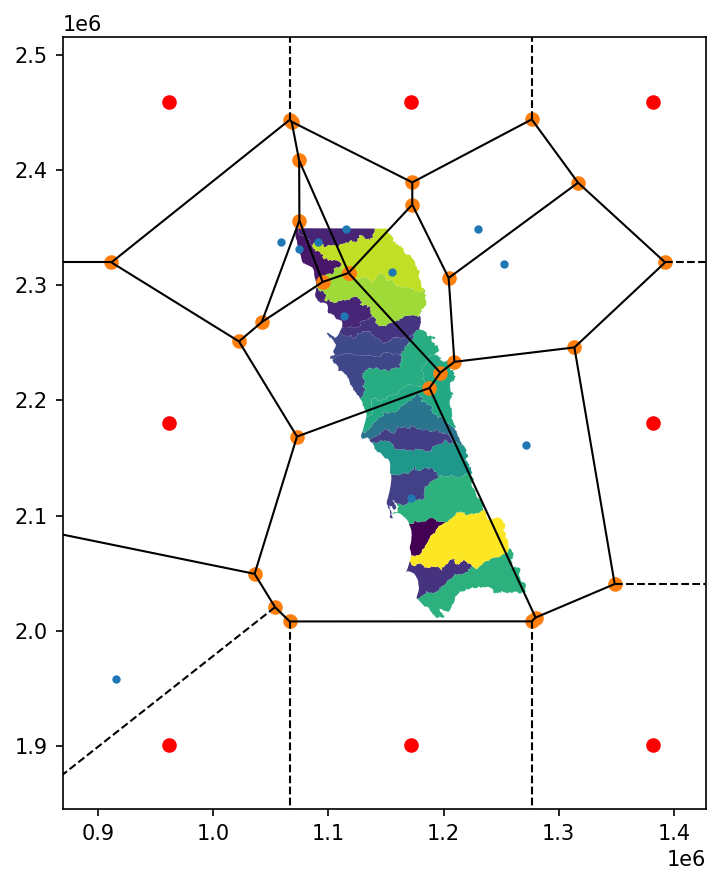

In [264]:
# Polígonos de Thiessen

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos las subcuenca.
subc[subc["CVE_RH"] == "RH01"].plot("AREA", ax = ax, zorder = 2)
# Graficamos los polígonos de Thiessen.
spatial.voronoi_plot_2d(Thiessen, ax = ax, zorder = 1)
# Graficamos los límites.
estaciones.loc[11:, "geometry"].plot(ax = ax, color = "r", zorder = 3)

fig.tight_layout()
plt.show()

In [297]:
estaciones = estaciones.iloc[:-8].copy()
estaciones

ESTACION    LATITUD    LONGITUD           ESTADO  \
0                 EJIDO_NUEVO_LEON  32.414440 -115.192500  Baja California   
1                    ISLA_CORONADO  32.415600 -117.248100  Baja California   
2                   ISLA_GUADALUPE  28.882800 -118.293100  Baja California   
3                       LARUMOROSA  32.272222 -116.205556  Baja California   
4                     MEXICALI_EMA  32.666670 -115.457778  Baja California   
5                   PLAYASROSARITO  32.377500 -117.071389  Baja California   
6   PRESAABELARDOLRODRIGUEZTIJUANA  32.447222 -116.908333  Baja California   
7   PRESAEMILIOLOPEZZAMORAENSENADA  31.891389 -116.603333  Baja California   
8                       SAN_FELIPE  31.028050 -114.846660  Baja California   
9                       SANQUINTIN  30.531667 -115.837500  Baja California   
10                          TECATE  32.566670 -116.661389  Baja California   

             MUNICIPIO  ALTITUD  \
0             Mexicali     14.0   
1              Tijuana     76.0   
2             Ensenada     23.0   
3               Tecate   1262.0   
4             Mexicali     14.0   
5   Playas de Rosarito     36.9   
6              Tijuana    156.0   
7             Ensenada     32.0   
8             Mexicali     27.0   
9             Ensenada     32.0   
10              Tecate    583.7   

                                              ARCHIVO  \
0              Estacion_EJIDO_NUEVO_LEON__90_dias.csv   
1                 Estacion_ISLA_CORONADO__90_dias.csv   
2                Estacion_ISLA_GUADALUPE__90_dias.csv   
3                    Estacion_LARUMOROSA__90_dias.csv   
4                  Estacion_MEXICALI_EMA__90_dias.csv   
5                Estacion_PLAYASROSARITO__90_dias.csv   
6   Estacion_PRESAABELARDOLRODRIGUEZTIJUANA__90_di...   
7   Estacion_PRESAEMILIOLOPEZZAMORAENSENADA__90_di...   
8                    Estacion_SAN_FELIPE__90_dias.csv   
9                    Estacion_SANQUINTIN__90_dias.csv   
10                       Estacion_TECATE__90_dias.csv   

                           geometry             x             y  \
0   POINT (1252350.014 2318259.450)  1.252350e+06  2.318259e+06   
1   POINT (1058643.571 2337659.122)  1.058644e+06  2.337659e+06   
2    POINT (915764.064 1958404.802)  9.157641e+05  1.958405e+06   
3   POINT (1155275.080 2311612.307)  1.155275e+06  2.311612e+06   
4   POINT (1229974.568 2348638.310)  1.229975e+06  2.348638e+06   
5   POINT (1074839.464 2331663.295)  1.074839e+06  2.331663e+06   
6   POINT (1091009.953 2337794.109)  1.091010e+06  2.337794e+06   
7   POINT (1113431.313 2273135.331)  1.113431e+06  2.273135e+06   
8   POINT (1271148.725 2161421.674)  1.271149e+06  2.161422e+06   
9   POINT (1171337.908 2115317.077)  1.171338e+06  2.115317e+06   
10  POINT (1115628.012 2348658.379)  1.115628e+06  2.348658e+06   

                                             Thiessen  
0   POLYGON ((1316789.800 2389152.066, 1392434.676...  
1   POLYGON ((1074749.334 2356291.876, 1074531.774...  
2   POLYGON ((1035847.391 2049408.315, 1053617.509...  
3   POLYGON ((1117550.695 2310977.677, 1172805.057...  
4   POLYGON ((1316789.800 2389152.066, 1204399.021...  
5   POLYGON ((1094972.637 2302951.373, 1042094.526...  
6   POLYGON ((1094972.637 2302951.373, 1117457.215...  
7   POLYGON ((1094972.637 2302951.373, 1117457.215...  
8   POLYGON ((1209384.430 2233564.055, 1197126.945...  
9   POLYGON ((1187752.631 2210872.616, 1279890.670...  
10  POLYGON ((1117550.695 2310977.677, 1172805.057...

In [298]:
estaciones["hp_TOT"] = pluviograma.sum().to_numpy()

estaciones

ESTACION    LATITUD    LONGITUD           ESTADO  \
0                 EJIDO_NUEVO_LEON  32.414440 -115.192500  Baja California   
1                    ISLA_CORONADO  32.415600 -117.248100  Baja California   
2                   ISLA_GUADALUPE  28.882800 -118.293100  Baja California   
3                       LARUMOROSA  32.272222 -116.205556  Baja California   
4                     MEXICALI_EMA  32.666670 -115.457778  Baja California   
5                   PLAYASROSARITO  32.377500 -117.071389  Baja California   
6   PRESAABELARDOLRODRIGUEZTIJUANA  32.447222 -116.908333  Baja California   
7   PRESAEMILIOLOPEZZAMORAENSENADA  31.891389 -116.603333  Baja California   
8                       SAN_FELIPE  31.028050 -114.846660  Baja California   
9                       SANQUINTIN  30.531667 -115.837500  Baja California   
10                          TECATE  32.566670 -116.661389  Baja California   

             MUNICIPIO  ALTITUD  \
0             Mexicali     14.0   
1              Tijuana     76.0   
2             Ensenada     23.0   
3               Tecate   1262.0   
4             Mexicali     14.0   
5   Playas de Rosarito     36.9   
6              Tijuana    156.0   
7             Ensenada     32.0   
8             Mexicali     27.0   
9             Ensenada     32.0   
10              Tecate    583.7   

                                              ARCHIVO  \
0              Estacion_EJIDO_NUEVO_LEON__90_dias.csv   
1                 Estacion_ISLA_CORONADO__90_dias.csv   
2                Estacion_ISLA_GUADALUPE__90_dias.csv   
3                    Estacion_LARUMOROSA__90_dias.csv   
4                  Estacion_MEXICALI_EMA__90_dias.csv   
5                Estacion_PLAYASROSARITO__90_dias.csv   
6   Estacion_PRESAABELARDOLRODRIGUEZTIJUANA__90_di...   
7   Estacion_PRESAEMILIOLOPEZZAMORAENSENADA__90_di...   
8                    Estacion_SAN_FELIPE__90_dias.csv   
9                    Estacion_SANQUINTIN__90_dias.csv   
10                       Estacion_TECATE__90_dias.csv   

                           geometry             x             y  \
0   POINT (1252350.014 2318259.450)  1.252350e+06  2.318259e+06   
1   POINT (1058643.571 2337659.122)  1.058644e+06  2.337659e+06   
2    POINT (915764.064 1958404.802)  9.157641e+05  1.958405e+06   
3   POINT (1155275.080 2311612.307)  1.155275e+06  2.311612e+06   
4   POINT (1229974.568 2348638.310)  1.229975e+06  2.348638e+06   
5   POINT (1074839.464 2331663.295)  1.074839e+06  2.331663e+06   
6   POINT (1091009.953 2337794.109)  1.091010e+06  2.337794e+06   
7   POINT (1113431.313 2273135.331)  1.113431e+06  2.273135e+06   
8   POINT (1271148.725 2161421.674)  1.271149e+06  2.161422e+06   
9   POINT (1171337.908 2115317.077)  1.171338e+06  2.115317e+06   
10  POINT (1115628.012 2348658.379)  1.115628e+06  2.348658e+06   

                                             Thiessen  hp_TOT  
0   POLYGON ((1316789.800 2389152.066, 1392434.676...    0.20  
1   POLYGON ((1074749.334 2356291.876, 1074531.774...    7.30  
2   POLYGON ((1035847.391 2049408.315, 1053617.509...    0.51  
3   POLYGON ((1117550.695 2310977.677, 1172805.057...   14.65  
4   POLYGON ((1316789.800 2389152.066, 1204399.021...    0.76  
5   POLYGON ((1094972.637 2302951.373, 1042094.526...   32.60  
6   POLYGON ((1094972.637 2302951.373, 1117457.215...   29.60  
7   POLYGON ((1094972.637 2302951.373, 1117457.215...   18.60  
8   POLYGON ((1209384.430 2233564.055, 1197126.945...    0.20  
9   POLYGON ((1187752.631 2210872.616, 1279890.670...    5.40  
10  POLYGON ((1117550.695 2310977.677, 1172805.057...   13.80

In [85]:
# Graficamos las isoyetas y las guardamos en una variable.
isoyetas = ax.tricontour( estaciones["x"],
    estaciones["y"], estaciones["hp_TOT"], levels = 15 )

# Extraemos las isoyetas y las convertimos en curvas de Shapely.

# Lista con el nivel de las isoyetas repetido
# por cada isoyeta que haya en ese nivel.
hp_level = []
# Cantidad de isoyetas que tiene un nivel.
level_n  = []
# Curvas de cada isoyeta.
level_c  = []

# Iteramos para todos los grupos de isoyetas allsegs.
# Evitamos el primer y último grupo que están vacíos.
for i in range( len(isoyetas.allsegs[1:-1]) ):
    # Contamos la cantidad de isoyetas que hay en un grupo, lo agregamos
    # a la lista level_n e imprimimos los valores.
    level_n.append( len( isoyetas.allsegs[1 + i] ) )
    print(f"nivel {i}: {level_n[i]}")

    # Copiamos el nivel de la isoyeta tantas
    # veces como isoyetas haya en ese nivel.
    hp_level = hp_level + [isoyetas.levels[i]] * level_n[i]

    # Entramos en cada grupo i, que tiene una cantidad level_n[i]
    # de elementos dentro, convertimos cada elemento en una
    # geometría de shapely y lo metemos dentro de una lista
    # de una sola dimensión (como hacer flatten).
    for j in range( 0, level_n[i] ):
        level_c.append( shp.geometry.LineString(isoyetas.allsegs[i + 1][j]) )

# Creamos un DataFrame con los niveles de isoyetas.
df_is = pd.DataFrame(hp_level, columns = ["hp [mm]"])
# Agregamos las geometrías de shapely.
df_is["geometry"] = level_c
# Convertimos en un GeoDataFrame.
df_is = gpd.GeoDataFrame(df_is)
# Establecemos que hemos estado trabajando con coordenadas UTM 11N (m).
df_is = df_is.set_crs(CRS)

df_is

nivel 0: 1
nivel 1: 1
nivel 2: 1
nivel 3: 1
nivel 4: 1
nivel 5: 1
nivel 6: 1
nivel 7: 1
nivel 8: 1
nivel 9: 1
nivel 10: 1
nivel 11: 1
nivel 12: 1


hp [mm]                                           geometry
0       0.0  LINESTRING (957638.912 2069555.921, 937508.554...
1       2.5  LINESTRING (1010245.505 2209193.005, 964825.75...
2       5.0  LINESTRING (1060396.938 2337997.561, 1058933.8...
3       7.5  LINESTRING (1082314.031 2342228.044, 1062562.3...
4      10.0  LINESTRING (1104231.124 2346458.528, 1066190.8...
5      12.5  LINESTRING (1129224.021 2230093.989, 1144289.0...
6      15.0  LINESTRING (1118256.863 2259983.810, 1122860.0...
7      17.5  LINESTRING (1077076.443 2337735.998, 1066773.5...
8      20.0  LINESTRING (1080704.961 2337751.131, 1068373.9...
9      22.5  LINESTRING (1084333.479 2337766.264, 1069974.2...
10     25.0  LINESTRING (1087961.998 2337781.397, 1071574.6...
11     27.5  LINESTRING (1082006.522 2320793.816, 1088853.8...
12     30.0  LINESTRING (1075115.120 2331245.238, 1075378.4...

In [86]:
# Graficamos las isoyetas.
df_is.explore()

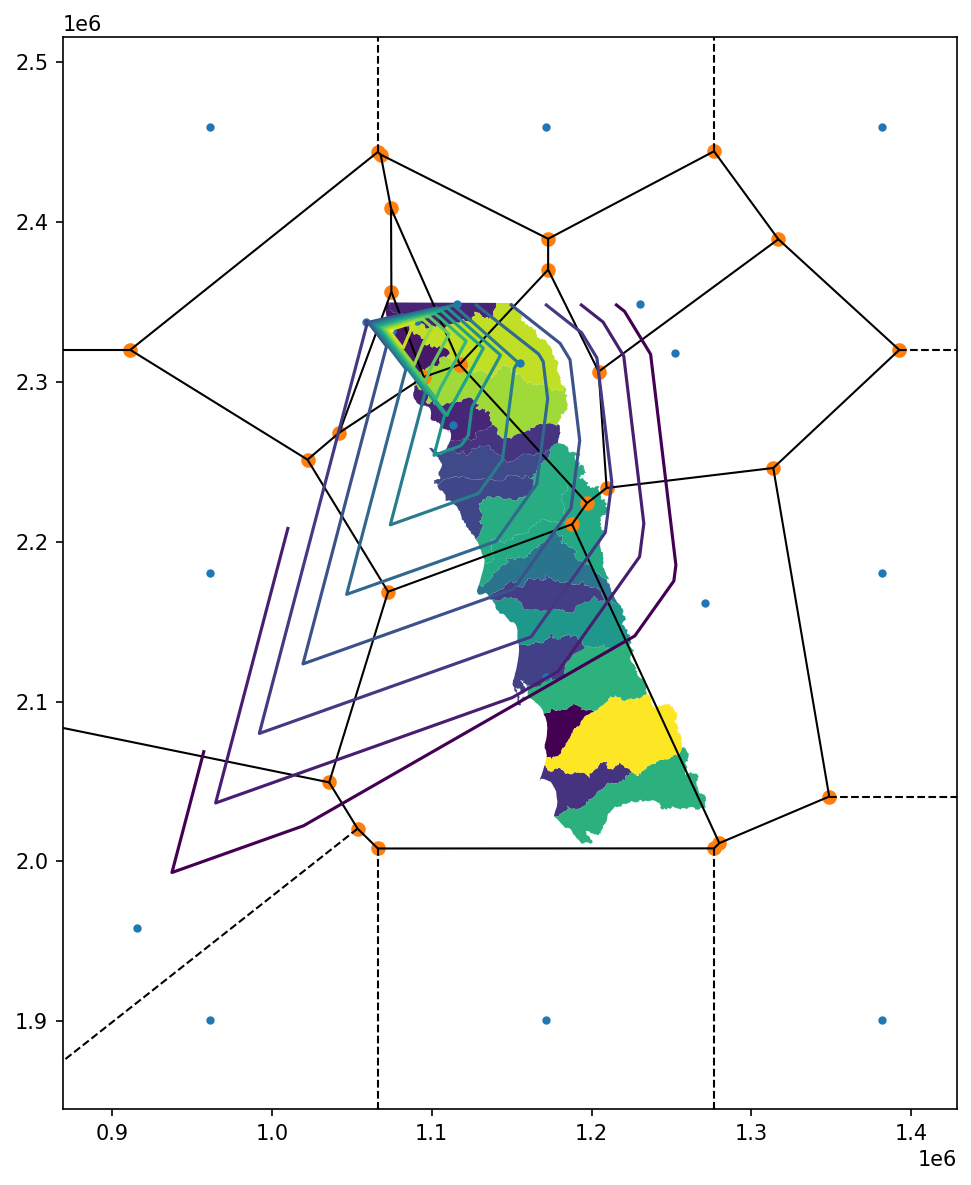

In [299]:
# Polígonos de Thiessen + isoyetas.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Graficamos las subcuenca.
subc[subc["CVE_RH"] == "RH01"].plot("AREA", ax = ax)
# Graficamos los polígonos de Thiessen.
spatial.voronoi_plot_2d(Thiessen, ax = ax)
# Graficamos las isoyetas.
df_is.plot("hp [mm]", ax = ax)

fig.tight_layout()
plt.show()

In [300]:
Subcuenca = subc[ subc["CVE_SUBCUE"] == "RH01Bd" ].reset_index(drop = True)

Subcuenca

CVE_SUBCUE     SUBCUENCA       TIPO          AREA      PERIMETRO  \
0     RH01Bd  A. El Salado  EXORREICA  1.868140e+09  407083.340466   

                                            geometry CVE_RH  
0  POLYGON ((1207948.053 2206741.772, 1207936.647...   RH01

In [301]:
Subcuenca.explore()

In [323]:
df_is[Subcuenca.loc[0, "CVE_SUBCUE"]] = df_is.intersection(
    Subcuenca.loc[0, "geometry"] )
subc_is = df_is.set_geometry(Subcuenca.loc[0, "CVE_SUBCUE"])

subc_is = subc_is[ ~ subc_is.is_empty ].reset_index(drop = True).copy()

subc_is[f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_AREA"] = None

for i in range( subc_is.shape[0] ):
    subc_is.loc[i, f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_AREA"] = shp.ops.split(
        Subcuenca.loc[0, "geometry"], subc_is.loc[i, "geometry"])[1]

subc_is

hp [mm]                                           geometry  \
0      5.0  LINESTRING (1060396.938 2337997.561, 1058933.8...   
1      7.5  LINESTRING (1082314.031 2342228.044, 1062562.3...   
2     10.0  LINESTRING (1104231.124 2346458.528, 1066190.8...   

                                              RH01Bd  \
0  MULTILINESTRING ((1194513.731 2185968.549, 120...   
1  MULTILINESTRING ((1173794.108 2202144.548, 117...   
2  LINESTRING (1137180.414 2199134.220, 1140191.1...   

                                         RH01Bd_AREA  
0  POLYGON ((1208433.408969529 2205542.263925106,...  
1  POLYGON ((1176474.339856406 2205913.464116898,...  
2  POLYGON ((1137180.413719016 2199134.219720469,...

In [321]:
estaciones[Subcuenca.loc[0, "CVE_SUBCUE"]] = ( estaciones[ "Thiessen"
    ].intersection( Subcuenca.loc[0, "geometry"] ) )
estaciones = estaciones.set_geometry(Subcuenca.loc[0, "CVE_SUBCUE"])

subc_th = estaciones[ ~ estaciones.is_empty ].copy()
subc_th[f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_AREA"] = subc_th.area

subc_th

ESTACION    LATITUD    LONGITUD           ESTADO  \
3                      LARUMOROSA  32.272222 -116.205556  Baja California   
7  PRESAEMILIOLOPEZZAMORAENSENADA  31.891389 -116.603333  Baja California   
8                      SAN_FELIPE  31.028050 -114.846660  Baja California   
9                      SANQUINTIN  30.531667 -115.837500  Baja California   

  MUNICIPIO  ALTITUD                                            ARCHIVO  \
3    Tecate   1262.0                   Estacion_LARUMOROSA__90_dias.csv   
7  Ensenada     32.0  Estacion_PRESAEMILIOLOPEZZAMORAENSENADA__90_di...   
8  Mexicali     27.0                   Estacion_SAN_FELIPE__90_dias.csv   
9  Ensenada     32.0                   Estacion_SANQUINTIN__90_dias.csv   

                          geometry             x             y  \
3  POINT (1155275.080 2311612.307)  1.155275e+06  2.311612e+06   
7  POINT (1113431.313 2273135.331)  1.113431e+06  2.273135e+06   
8  POINT (1271148.725 2161421.674)  1.271149e+06  2.161422e+06   
9  POINT (1171337.908 2115317.077)  1.171338e+06  2.115317e+06   

                                            Thiessen  \
3  POLYGON ((1117550.695 2310977.677, 1172805.057...   
7  POLYGON ((1094972.637 2302951.373, 1117457.215...   
8  POLYGON ((1209384.430 2233564.055, 1197126.945...   
9  POLYGON ((1187752.631 2210872.616, 1279890.670...   

                                              RH01Bd   RH01Bd_AREA  
3  POLYGON ((1197126.945 2224107.277, 1185820.218...  1.513188e+08  
7  POLYGON ((1197126.945 2224107.277, 1187752.631...  5.178663e+08  
8  POLYGON ((1187752.631 2210872.616, 1197126.945...  6.165250e+08  
9  POLYGON ((1200483.074 2183312.762, 1200457.408...  5.824298e+08

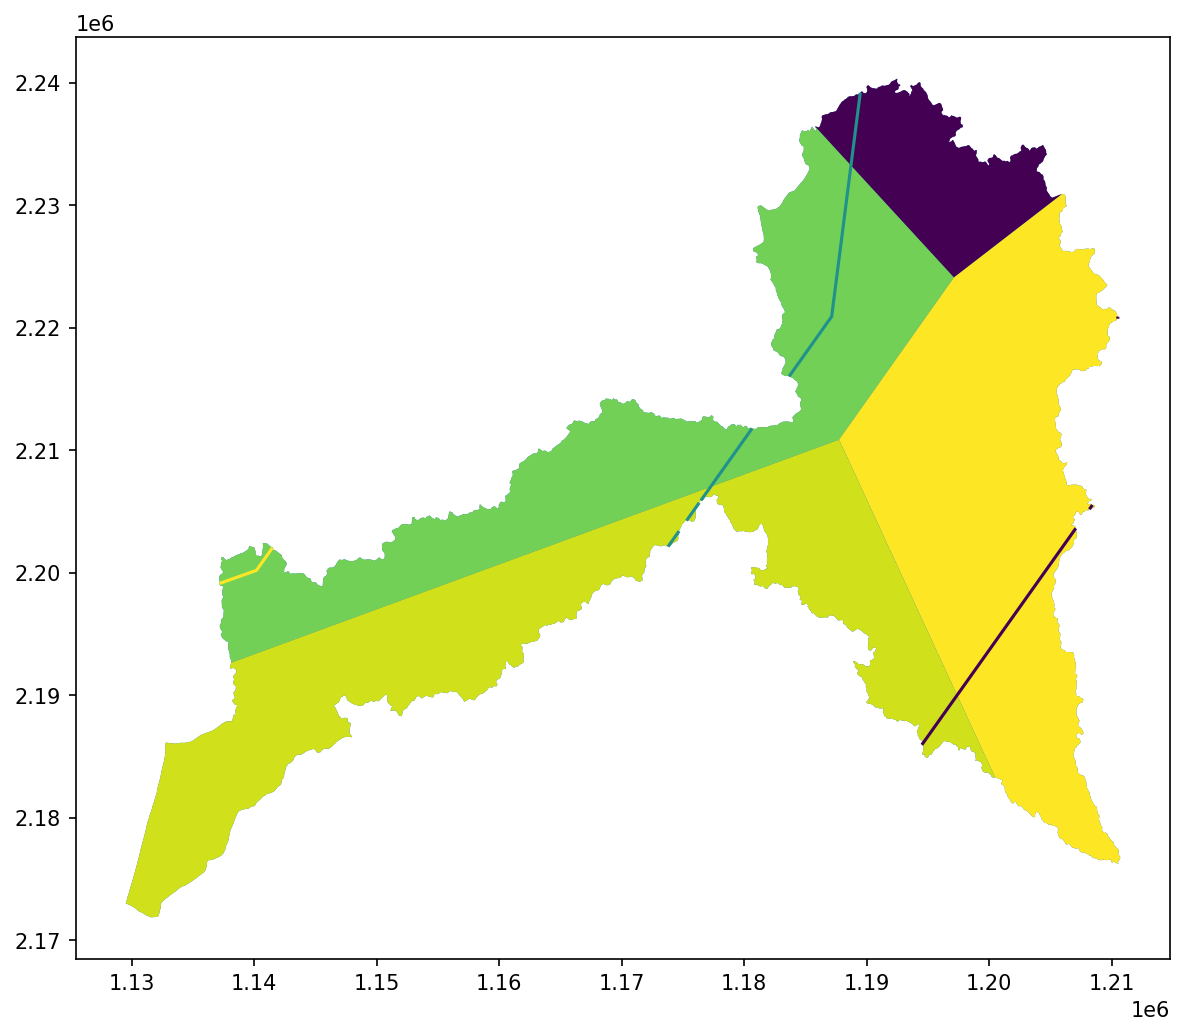

In [324]:
# Polígonos de Thiessen

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Graficamos la subcuenca.
Subcuenca.plot(ax = ax)
# Graficamos los polígonos de Thiessen.
subc_th.plot(f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_AREA", ax = ax)
# Graficamos las isoyetas.
subc_is.plot("hp [mm]", ax = ax)

fig.tight_layout()
plt.show()